In [1]:
import copy
import warnings

import numpy as np
import xarray as xr

import sys, pdb, traceback

import matplotlib.pyplot as plt

import rotunno as rt
import qian_helpers
import rotunno_helpers

In [2]:
# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport rotunno 

In [117]:
theta0=300
N=0.01
h=1500
delTheta=8
latitude=-10
beta, Atilde, f, h = rt.calc_rotunno_parameters(N=N,theta0=theta0,delTheta=delTheta,latitude=latitude)

In [45]:
ds_qian = xr.open_dataset('/home/student.unimelb.edu.au/shorte1/Documents/rotunno83/datasets/nice_weak_bg_wind_example.nc')

In [87]:
ds_qian = rt.solve_qian(xiN=41, zetaN=41, tauN=32, sN=1000, U=0.4, L=0.1, alpha=3, save=False)
# ds_rotunno = rt.solve_rotunno_case_two(xiN=41, zetaN=41, tauN=32, kN=1000,
#                                        xi0=0.1, beta=beta, Atilde=Atilde)

Initialising
Integrating
100%|██████████| 40/40 [03:35<00:00,  5.38s/it]
Saving


In [5]:
ds_qian.to_netcdf('/home/student.unimelb.edu.au/shorte1/Documents/rotunno83/datasets/qian.nc')
ds_rotunno.to_netcdf('/home/student.unimelb.edu.au/shorte1/Documents/rotunno83/datasets/rotunno.nc')

In [7]:
ds_qian = xr.open_dataset('/home/student.unimelb.edu.au/shorte1/Documents/rotunno83/datasets/qian.nc')
ds_rotunno = xr.open_dataset('/home/student.unimelb.edu.au/shorte1/Documents/rotunno83/datasets/rotunno.nc')

In [118]:
omega = 2*np.pi/(24*3600)
# ds_rotunno_dim = rt.redimensionalise_rotunno(copy.deepcopy(ds_rotunno), h=h, f=f, N=N)
ds_qian_dim = rt.redimensionalise_qian(copy.deepcopy(ds_qian), h=h, N=N, Q0=Atilde*omega**3*h*np.pi)

In [119]:
g=9.807
ds_qian_dim['theta_q'] = (ds_qian_dim.bq)*theta0/g
ds_qian_dim['theta_w'] = (ds_qian_dim.bw)*theta0/g
ds_qian_dim['theta_q'].attrs['units'] = 'K'
ds_qian_dim['theta_w'].attrs['units'] = 'K'

Plotting theta_w.


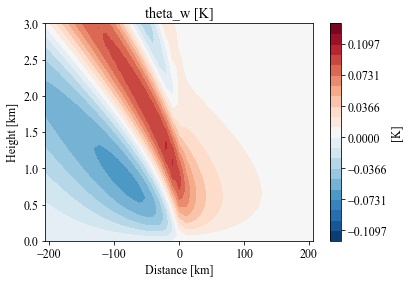

In [123]:
# rt.plotCont(ds_rotunno_dim, var='u',t=16); plt.show()
rt.plotCont(ds_qian_dim.sel(mode=[1]).sum(dim='mode', keep_attrs=True).squeeze(), var='theta_w',t=4); plt.show()

Plotting theta_w.
Timestep 0
Timestep 0
Timestep 1
Timestep 2
Timestep 3
Timestep 4
Timestep 5
Timestep 6
Timestep 7
Timestep 8
Timestep 9
Timestep 10
Timestep 11
Timestep 12
Timestep 13
Timestep 14
Timestep 15
Timestep 16
Timestep 17
Timestep 18
Timestep 19
Timestep 20
Timestep 21
Timestep 22
Timestep 23
Timestep 24
Timestep 25
Timestep 26
Timestep 27
Timestep 28
Timestep 29
Timestep 30
Timestep 31


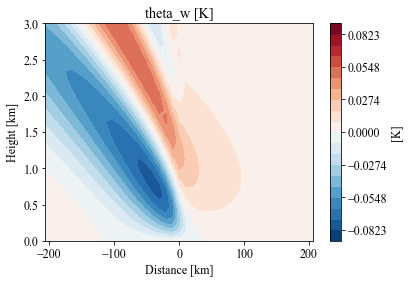

In [111]:
# rt.animateCont(ds_qian_dim.sum(dim='mode', keep_attrs=True).squeeze(),var='psi')
# rt.animatePsi(ds_dim.sel(mode=2).squeeze())
rt.animateCont(ds_qian_dim.sel(mode=[1]).sum(dim='mode', keep_attrs=True).squeeze(),  var='theta_w')

# rt.animateCont(ds_qian_dim.sum(dim='mode', keep_attrs=True).squeeze(),  var='theta_w')
# rt.animateCont(ds_qian_dim.sel(mode=[2]).sum(dim='mode', keep_attrs=True).squeeze(),  var='psi')
# for i in np.arange(1,7):
#     rt.animateCont(ds_qian_dim.sel(submode=i),  var='bw')
# rt.animateCont(ds_qian_dim.sel(submode=[2,3,4,5,6]).sum(dim='submode', keep_attrs=True).squeeze(),'bw')
# rt.animateCont(ds_qian_dim.sel(mode=2).squeeze(),  var='psi')

In [ ]:
ds_qian_dim['theta_pert'] = ds_qian_dim.bw*300/9.807
ds_qian_dim.theta_pert.attrs['units'] = 'K'

In [52]:
rt.animateVelocity(ds_qian_dim.sum(dim='mode', keep_attrs=True).squeeze()); plt.show()

Plotting velocity.
Timestep 0
Timestep 0
Timestep 1
Timestep 2
Timestep 3
Timestep 4
Timestep 5
Timestep 6
Timestep 7
Timestep 8
Timestep 9
Timestep 10
Timestep 11
Timestep 12
Timestep 13
Timestep 14
Timestep 15


## Buoyancy debug

In [ ]:
from sympy import *

In [ ]:
kappa, U, x, tau, L =symbols('kappa U x tau L')
kappaU = 1/U

In [ ]:
expression = (kappa/(kappa*U-1))/(kappa**2+(U*kappa-1)**2)*exp(-kappa*L)*exp(I*(kappa*x-tau))-(2*kappaU-kappa)/(kappa*U-1)/((2*kappaU-kappa)**2+(kappa*U-1)**2)*exp(-1*(2*kappaU-kappa)*L)*exp(I*((2*kappaU-kappa)*x-tau))

In [ ]:
simplify(expression)

In [ ]:
init_printing()
expression

In [ ]:
limit(expression,kappa,kappaU)

In [ ]:
simplify(cancel(factor(cancel(expand(exp)))))

In [ ]:
theta_alt = ((1-cos(s*pi))/(2))**(alpha)*pi/2

In [ ]:
theta_alt.subs(alpha,5)

In [ ]:
diff(theta_alt.subs(alpha,2),s)

In [ ]:
init_printing()

In [ ]:
plt.close('all')
power=6
tau=np.pi/2
zeta=0.001
alpha=3
U=1.5
L=0.1
sN=1000
dS=1/sN

s=np.arange(dS,1,dS, dtype=np.float32)
xi=np.linspace(-20,20,1000, dtype=np.float32)
theta=qian_helpers.calc_theta(s,alpha)

k2 = qian_helpers.calc_k_2(theta,U)
k3 = qian_helpers.calc_k_3(theta,U)
k0_2 = qian_helpers.calc_k_2(0,U)
k0_3 = qian_helpers.calc_k_3(0,U)
bw23=np.zeros(xi.size)
bw23_alt=np.zeros(xi.size)
bw23a=np.zeros(xi.size)
bw23b=np.zeros(xi.size)
bw2b=np.zeros(xi.size)
bw2ba=np.zeros(xi.size)
bw2c=np.zeros(xi.size)
bw3b=np.zeros(xi.size)
bw3c=np.zeros(xi.size)

# def calc_k_2()

def calc_test(xi,zeta,tau,theta,U,L):
    test_exp = (
        U**2*(-(U**2 + (U**2*(-np.sin(theta) + 1) - 1)**2)
              *np.exp((-L*(np.sin(theta) - 1)**2 + 1j*(U*tau*(-np.sin(theta) + 1) - xi))/(U*(-np.sin(theta) + 1)))
              +(U**2*(np.sin(theta) - 1)**2 + (U**2 + np.sin(theta) - 1)**2)
              *np.exp((L + 1j*(np.sin(theta) - 1)*(U*tau + xi*np.sin(theta) - xi))/(U*(np.sin(theta) - 1))))
        *np.exp(1j*(-U*tau*(-np.sin(theta) + 1) + xi - (-np.sin(theta) + 1)*(U*tau + xi*np.sin(theta) - xi))/(U*(-np.sin(theta) + 1)))
        /((U**2 + (U**2*(-np.sin(theta) + 1) - 1)**2)
          *(U**2*(np.sin(theta) - 1)**2 + (U**2 + np.sin(theta) - 1)**2)
          *np.tan(theta))
    )
    return test_exp

for i in range(xi.size):
    bw23a_ig = (1/np.tan(theta)
               *(
                 -qian_helpers.calc_C2(xi[i],tau,k2,U,L)/U**2
#                  +qian_helpers.calc_C3(xi[i],tau,k3,U,L)
                )
               *alpha*s**(alpha-1)*np.pi/2)
    bw23b_ig = (1/np.tan(theta)
               *(
#                  -qian_helpers.calc_C2(xi[i],tau,k2,U,L)/U**2
                 +qian_helpers.calc_C3(xi[i],tau,k3,U,L)
                )
               *alpha*s**(alpha-1)*np.pi/2)
    bw23_ig = ((-qian_helpers.calc_C2(xi[i],tau,k2,U,L)/U**2/np.tan(theta)
                +qian_helpers.calc_C3(xi[i],tau,k3,U,L)/np.tan(theta))
               *alpha*s**(alpha-1)*np.pi/2)
    
    s_app=np.concatenate(([0],s,[1]))
    bw23_ig_app=np.concatenate(([0],bw23_ig,[0]))
    
#     bw23_ig_alt = calc_test(xi[i],zeta,tau,theta,U,L)*alpha*s**(alpha-1)*np.pi/2
    
    bw23a[i] = np.trapz(bw23a_ig,s)*1/2*np.exp(-zeta)
    bw23b[i] = np.trapz(bw23b_ig,s)*1/2*np.exp(-zeta)
    bw23[i] = np.trapz(bw23_ig_app,s_app)*1/2*np.exp(-zeta)
#     bw23_alt[i] = np.trapz(bw23_ig_alt,s)*1/2*np.exp(-zeta)
    bw2c[i] = (1/(2*U**2)*np.exp(1j*zeta/U)
               *qian_helpers.calc_C2(xi[i],tau,k0_2,U,L)
               *qian_helpers.calc_exp1(1j*zeta/U))
    bw2b[i] = np.trapz(qian_helpers.calc_bw2b(xi[i],zeta,tau,s,alpha,U,L),s)
    bw3b[i] = np.trapz(qian_helpers.calc_bw3b(xi[i],zeta,tau,s,alpha,U,L),s)
    bw3c[i] = (-1/2*qian_helpers.calc_C3(xi[i],tau,k0_3,U,L)
                        *qian_helpers.calc_exp1(-1j*zeta/U))
    
    # Calc psi2
    psi2a_ig = qian_helpers.calc_psi2a(xi[i],zeta,tau,s,alpha,U,L)
    psi2b_ig = qian_helpers.calc_psi2b(xi[i],zeta,tau,s,alpha,U,L)
    
    psi2c = (-1/(2*U)*np.exp(1j*zeta/U)
             *qian_helpers.calc_C2(xi[i],tau,k0_2,U,L)
             *qian_helpers.calc_ep0(-1j*zeta/U))

    psi2ab = np.trapz(psi2a_ig+psi2b_ig, s)
    bw2ba[i] = (psi2ab+psi2c)/U
        
# plt.figure(figsize=(12,8))
# plt.plot(xi,bw23a,label='bw23a')
# plt.plot(xi,bw23b,label='bw23b')
# plt.plot(xi,bw23_alt,label='bw23')
# plt.plot(xi,np.zeros(xi.size),'--k')
# plt.plot(xi,bw2b,label='bw2b')
# plt.plot(xi,bw2c,label='bw2c')
# plt.plot(xi,bw3b,label='bw3b')
# plt.plot(xi,bw3c,label='bw3c')
# plt.plot(s,k2,'.')
# plt.plot(s[0:4000],k3[0:4000]-1.25,'.')

# plt.figure(figsize=(12,8))
# plt.plot(s[0:800],k3[0:800],'.')

# plt.legend()
# plt.show()
plt.figure(figsize=(12,8))

# plt.plot(xi,bw2ba,label='bw2ba')
# plt.plot(xi,bw3b+bw3c+bw2b,label='bw3b+bw3c')
plt.plot(xi,bw2b+bw2c+bw3b+bw3c,label='all')
# plt.plot(xi,bw2c,label='bw2b+bw2c')
# plt.plot(xi,bw23_alt,label='bw23_alt')
# plt.plot(xi,bw23a,label='bw23a')
# plt.plot(xi,bw23b,label='bw23b')
# plt.plot(xi,bw23,label='bw23')
# plt.plot(xi,bw23+bw2ba,label='bw23')
# plt.plot(xi,bw3b+bw3c+bw23+bw23+bw2c,label='all')
# plt.plot(xi,bw23a+bw23b,label='bw23a+bw23b')
# plt.plot(xi,bw23,label='bw23')
plt.plot(xi,np.zeros(xi.size),'--k')
plt.legend()
plt.show()

In [ ]:
plt.plot(k3_alt[0:4000])

In [ ]:
bw23_ig_app[np.isnan(bw23_ig_app)]=0

In [ ]:
bw23_ig_app

In [ ]:
print(bw23b_ig[-1])
print(bw23a_ig[-1])
print(bw23_ig[-1])

print(bw23b_ig[0])
print(bw23a_ig[0])
print(bw23_ig[0])

In [ ]:
s_app=np.concatenate(([0],s,[1]))
bw23_ig_app=np.concatenate(([0],bw23_ig,[0]))

plt.plot(s_app,bw23_ig_app)
plt.plot(s_app,np.zeros(s_app.size),'--k');
plt.show()

# plt.plot(s[200:],bw23a_ig[200:])
# plt.plot(s[200:],bw23b_ig[200:])

In [ ]:

k2_app = np.concatenate((k2,[0]))
plt.plot(k2_app[-10:],'.'); plt.show()

In [ ]:
plt.plot(bw23a_ig); plt.show()

In [ ]:
plt.plot(s[0:30000],k3[0:30000],'.')
plt.plot(s,k2,'.')

In [ ]:
def calc_theta_alt(s,alpha=1):
    theta_alt = ((1-np.cos(s*np.pi))/(2))**(alpha)*np.pi/2
    return theta_alt

def calc_dtheta_alt(s,alpha=1):
    dtheta_alt = (np.pi/2*alpha*((1-np.cos(s*np.pi))/2)**(alpha-1)
                  *np.sin(s*np.pi)*np.pi/2)
    return dtheta_alt

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(s[200:2500],k3[200:2500],'.',size=0.1)

In [ ]:
plt.plot(s,k2,'.')

In [ ]:
# plt.plot(s,theta_alt)
alpha=0.75
theta_alt=calc_theta_alt(s,alpha)
k2 = qian_helpers.calc_k_2(theta_alt,U)
k3 = qian_helpers.calc_k_3(theta_alt,U)

plt.plot(s,calc_theta_alt(s, alpha))
# plt.plot(s,calc_theta_alt(s))
# k2_alt = qian_helpers.calc_k_2(calc_theta_alt(s),U)
# k3_alt = qian_helpers.calc_k_3(calc_theta_alt(s),U)
# plt.plot(s[0:100],k3_alt[0:100],'.')
plt.plot(s,calc_dtheta_alt(s,alpha=alpha))
plt.plot(s,k2)
plt.plot(s[:-3000],k3[:-3000])

In [ ]:
x=-20.10
alpha=3
U=0.6
tau=3
L=0.1
sN=5000
dS=1/sN

s=np.arange(dS,1,dS,dtype=np.float128)
theta=calc_theta_alt(s,alpha)

k2 = qian_helpers.calc_k_2(theta,U)
k3 = qian_helpers.calc_k_3(theta,U)
k0_2 = qian_helpers.calc_k_2(0,U)
k0_3 = qian_helpers.calc_k_3(0,U)

# bw23a_ig = (1/np.tan(theta)
#                *(
#                  -qian_helpers.calc_C2(x,tau,k2,U,L)/U**2
# #                  +qian_helpers.calc_C3(xi[i],tau,k3,U,L)
#                 )
#                *alpha*s**(alpha-1)*np.pi/2)
# bw23b_ig = (1/np.tan(theta)
#            *(
# #                  -qian_helpers.calc_C2(xi[i],tau,k2,U,L)/U**2
#              +qian_helpers.calc_C3(x,tau,k3,U,L)
#             )
#            *alpha*s**(alpha-1)*np.pi/2)

bw23a_ig = (1/np.tan(theta)
               *(
                 -qian_helpers.calc_C2(x,tau,k2,U,L)/U**2
#                  +qian_helpers.calc_C3(xi[i],tau,k3,U,L)
                )
#                *alpha*s**(alpha-1)*np.pi/2)*1/2*np.exp(-zeta)
                *calc_dtheta_alt(s,alpha))
bw23b_ig = (1/np.tan(theta)
           *(
#                  -qian_helpers.calc_C2(xi[i],tau,k2,U,L)/U**2
             +qian_helpers.calc_C3(x,tau,k3,U,L)
            )
#            *alpha*s**(alpha-1)*np.pi/2)*1/2*np.exp(-zeta)
            *calc_dtheta_alt(s,alpha))
bw23_ig = (1/np.tan(theta)
           *(
             -qian_helpers.calc_C2(x,tau,k2,U,L)
             +qian_helpers.calc_C3(x,tau,k3,U,L)*U**2
            )
#            *alpha*s**(alpha-1)*np.pi/2)*1/2*np.exp(-zeta)
            *calc_dtheta_alt(s,alpha))

where_nan = np.logical_or(np.isnan(bw23a_ig),np.isnan(bw23b_ig))
bw23a_ig[where_nan]=0
bw23b_ig[where_nan]=0
bw23_ig[np.isnan(bw23_ig)]=0

# plt.plot(theta[3:10],bw23a_ig[3:10],label='a')
# plt.plot(theta[3:10],bw23b_ig[3:10],label='b')
# plt.plot(theta,(bw23b_ig+bw23a_ig),label='a+b')
plt.plot(theta,bw23_ig/U**2, label='a+b')
plt.plot(theta, np.zeros(theta.size),'--k')
plt.legend()

# s_app = np.concatenate(([0],s,[1]))
# bw

print(np.trapz(bw23a_ig,s))
print(np.trapz(bw23b_ig,s))
print(np.trapz(bw23a_ig,s)+np.trapz(bw23b_ig,s))
print(np.trapz(bw23a_ig+bw23b_ig,s))
print(np.trapz(bw23_ig/U**2,s))


In [ ]:
plt.plot(np.tan(np.arange(0,np.pi/8,np.pi/(2*5000)))+1/U,'.')

In [ ]:
# Alternative approach
sN=2000
dk = (1/U)/sN
s=np.arange(1/sN,1,1/sN)
U=0.5
L=0.5
alpha=1

k2 = (1-s**alpha)/U

k3 = np.tan((np.arange(0,1+1/sN,1/sN))*np.pi/2)+2/U
x=10
tau=0
zeta=0.00001

def calc_exp_terms(xi,tau,k,L):
    return np.exp(-k*L)*np.exp(1j*(k*xi-tau)) 

# bw2a_ig = qian_helpers.calc_C2(x,tau,k2,U,L)*k2/(U*k2-1)*alpha*s**(alpha-1)
bw2a_ig = qian_helpers.calc_C2(x,tau,k2,U,L)*k2*alpha*s**(alpha-1)
# bw2a_ig_alt = qian_helpers.calc_C2(x,tau,k2,U,L)*alpha*s**(alpha-1)
bw2a_ig[np.isinf(bw2a_ig)]=0

k2P = -k2+2/U

# bw3a1_ig = qian_helpers.calc_C2(x,tau,k2P,U,L)*k2P/(1-U*k2)*alpha*s**(alpha-1)
bw3a1_ig = qian_helpers.calc_C2(x,tau,k2P,U,L)*k2P*alpha*s**(alpha-1)
# bw3a1_ig_alt = qian_helpers.calc_C2(x,tau,k2P,U,L)*alpha*s**(alpha-1)
bw3a1_ig[np.isinf(bw3a1_ig)]=0

bw3a2_ig = qian_helpers.calc_C2(x,tau,k3,U,L)*k3/(U*k3-1)

# plt.plot(k2[-10:],'o')
# plt.plot(k3[:10],'o')
# plt.plot(k3[:10]*0+2,'--')

# *np.exp(-zeta)

lb=0
ub=100

# plt.plot(s,bw2a_ig+bw3a1_ig)
plt.plot(s,bw2a_ig,label='bw2a')
plt.plot(s,bw3a1_ig, label='bw3a1')
plt.plot(s,(-bw3a1_ig+bw2a_ig)/(k2*U-1), label='sum')
plt.legend()
print(np.trapz((-bw3a1_ig+bw2a_ig)/(k2*U-1),s))
plt.plot()
# plt.plot(k2,bw2a_ig)
plt.figure()
plt.plot(np.arange(0,1+1/sN,1/sN),bw3a2_ig)
print(np.trapz(bw3a2_ig,k3))

# plt.plot(np.concatenate((bw2a_ig,bw3a_ig)))
# print(np.trapz(bw2a_ig[:100],k2[:100]))
# print(np.trapz(bw3a_ig[100:],k3[100:]))
# print(np.trapz(bw2a_ig[-100:],k2[-100:]))
# print(np.trapz(bw3a_ig[0:100],k3[0:100]))

In [ ]:
-2*0.5*np.exp(-1)-2*0.5*np.exp(-1)

In [ ]:
((-bw3a1_ig+bw2a_ig)/(k2*U-1))[0]

In [ ]:
(-bw3a1_ig+bw2a_ig)

In [ ]:
print(bw2a_ig[0:5])
print(bw3a1_ig[0:5])

In [ ]:
plt.plot(s,k2)

In [ ]:
(bw2a_ig)[:10]
(bw3a1_ig)[:10]

In [ ]:
print(bw3a1_ig[[0,-1]])
print(bw2a_ig[[0,-1]])

In [ ]:
(bw2a_ig+bw3a1_ig)[-1]

In [ ]:
(bw2a_ig+bw3a1_ig)[-10:]

In [ ]:
plt.plot(k2P)

In [ ]:
np.trapz(bw3a2_ig,s)

In [ ]:
lb=0
ub=None
print(np.trapz(bw23_ig[lb:ub],s[lb:ub]))
print(theta[lb])
print(theta[ub])
print('k2 bounds')
print(k2[lb])
print(k2[ub])
print('k3 bounds')
print(k3[lb])
print(k3[ub])

In [ ]:
bw23_ig.max()

In [ ]:
plt.plot(k3[0:800],'.')

In [ ]:
np.logical_or(np.isnan(bw23a_ig),np.isnan(bw23b_ig))

# bw23b_ig[-10:]

In [ ]:
plt.plot(theta)

In [ ]:
ig=(bw23b_ig+bw23a_ig)
ig[np.isnan(bw23b_ig+bw23a_ig)]=0
np.trapz(ig,s)

In [ ]:
bw23_ig_alt_1 = calc_test(-10.00,zeta,6*2*np.pi/10,theta,U,L)*alpha*s**(alpha-1)*np.pi/2
bw23_ig_alt_2 = calc_test(-10.20,zeta,6*2*np.pi/10,theta,U,L)*alpha*s**(alpha-1)*np.pi/2
bw23_ig_alt_3 = calc_test(-10.40,zeta,6*2*np.pi/10,theta,U,L)*alpha*s**(alpha-1)*np.pi/2
bw23_ig_alt_4 = calc_test(-10.60,zeta,6*2*np.pi/10,theta,U,L)*alpha*s**(alpha-1)*np.pi/2

plt.plot(bw23_ig_alt_1)
print(np.trapz(bw23_ig_alt_1,s)*1/2*np.exp(-zeta))
plt.plot(bw23_ig_alt_2)
print(np.trapz(bw23_ig_alt_2,s)*1/2*np.exp(-zeta))
plt.plot(bw23_ig_alt_3)
print(np.trapz(bw23_ig_alt_3,s)*1/2*np.exp(-zeta))
plt.plot(bw23_ig_alt_4)
print(np.trapz(bw23_ig_alt_4,s)*1/2*np.exp(-zeta))

In [ ]:
k3[8000]

In [ ]:
len(k2)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(s[0:500],k3[0:500],'.')